In [1]:
from typing import ContextManager
from astropy.io.fits import hdu
from Spectra import *
from SpectraData import *
from Inventory import *
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import sys, os
import numpy as np
from rescaleSky import *
import glob 
from mergeExpositions import *
from HighSeeing import HighSeeing_Filter
import warnings
from astropy.stats import sigma_clip
import seaborn as sns
from Tools import *
import pandas
warnings.filterwarnings('ignore')

print(os.getcwd())

/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/B-CalibrationCode


In [2]:
data_dir = 'A-Catalog/data/'
#slits = pd.read_csv(data_dir+'BLAS_1_slits.csv')


fname_data1 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask1/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err1  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask1/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))
fname_data2 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_1/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err2  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_1/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))
fname_data3 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_2/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err3  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_2/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))
fname_data4 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_3/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err4  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_3/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))


def Reduction(fname_data,fname_err,mask_name,SCALEs=None):
    EXP_data=[] # this should have size galxy number * exp number
    EXP_times=[] # this should have size galaxy number * exp number
    EXP_errs=[]
    Ypix=[]
    MasknonDetect    =   nonDetections_everything(pandas.read_csv('../Docs/'+mask_name+'.csv',sep=";"))

    contar=0
    for data,err in zip(fname_data[:],fname_err[:]):
        print(contar, data)
        if HighSeeing_Filter(data,mask_name) == False:
            print(data,": Skipped")
            continue

        hdu_list_flux = fits.open(data)
        hdu_list_err = fits.open(err)

        Specs=[]

        expositions=[]
        expositions_errors=[]
        exposition_times=[]
        ypix=[]


        for i in range(0,len(hdu_list_flux)): # only for a couple, not len(hdu_list_flux)
            if "ImageHDU" in str(hdu_list_flux[i]): # WE ONLY GRAB ImageHDU 's
                flux=hdu_list_flux[i]
                error=hdu_list_err[i]
                Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux) #Spectra object needs ID,RA,DEC,Z & SpectraData object where we put our spectra
            
        

        Skies=[]
        for s in np.array(Specs)[MasknonDetect]: 
            Skies.append(s.Data.skySpectra())
        SSpectra=np.nanmedian(Skies,axis=0)

        for s in Specs:
            exposition_times.append(s.expTime)
            ypix.append(s.Ypix)
            sScale=None
            if "HST" in s.Data.header["SLITOBJ"]:
                sScale=SCALEs[contar]
            
            if mask_name in ["Mask1"]:
                s.Data.processSlit(SSpectra,skyscale=sScale)
            dat = s.Data.rawData
            err = s.Data.error
            
            expositions.append(dat)
            expositions_errors.append(err)

        contar+=1
        hdu_list_flux.close()
        hdu_list_err.close()    
        

        EXP_data.append(expositions)
        EXP_errs.append(expositions_errors)
        EXP_times.append(exposition_times)
        Ypix.append(ypix)



    D=np.transpose(EXP_data,axes=[1,0])
    E=np.transpose(EXP_errs,axes=[1,0])
    T=np.transpose(EXP_times)
    Y=np.transpose(Ypix)


    for i in range(0,len(Specs)):
        s=Specs[i]
        d,e,y=mergeExpositions(D[i],E[i],T[i],Y[i])
        s.Data.save2fitsNew(d,e,y,folder=data_dir+"large_files/Reduced_Data/"+mask_name+"/2D/")

    return





###
# Get Noise so sigma(S/N) = 1
###







In [3]:
#A_1=Obtain_As(fname_data1,fname_err1,"Mask1",)
#A_2=Obtain_As(fname_data2,fname_err2,"Mask2_1",)
#A_3=Obtain_As(fname_data3,fname_err3,"Mask2_2",)
#A_4=Obtain_As(fname_data4,fname_err4,"Mask2_3",)
#np.save("files/MinimizationData_mask1.npy",A_1)
#np.save("files/MinimizationData_mask2.npy",A_2)
#np.save("files/MinimizationData_mask3.npy",A_3)
#np.save("files/MinimizationData_mask4.npy",A_4)


In [4]:
MinProps_1=np.load("../A-Catalogs/files/MinimizationData_mask1.npy",allow_pickle=True)
MinProps_2=np.load("../A-Catalogs/files/MinimizationData_mask2.npy",allow_pickle=True)
MinProps_3=np.load("../A-Catalogs/files/MinimizationData_mask3.npy",allow_pickle=True)
MinProps_4=np.load("../A-Catalogs/files/MinimizationData_mask4.npy",allow_pickle=True)

A_1,A_2,A_3,A_4 =   np.median(np.transpose(MinProps_1)[0],axis=0),np.median(np.transpose(MinProps_2)[0],axis=0),np.median(np.transpose(MinProps_3)[0],axis=0),np.median(np.transpose(MinProps_4)[0],axis=0)

#Reduction(fname_data1,fname_err1,"Mask1",A_1)
#Reduction(fname_data2,fname_err2,"Mask2_1",A_2)
#Reduction(fname_data3,fname_err3,"Mask2_2",A_3)
#Reduction(fname_data4,fname_err4,"Mask2_3",A_4)


FileNotFoundError: [Errno 2] No such file or directory: '../A-Catalogs/files/MinimizationData_mask1.npy'

#  FIX NOISE
## Noise is overestimated..

In [ ]:
def FixNoise(mask_name):
    Specs = readALLData("large_files/Reduced_Data/"+mask_name+"/2D/*.fits")
    NoiseScales=ScaleNoise(mask_name)
    print(NoiseScales)
    for i in range(0,len(Specs)):
        s=Specs[i]
        s.Data.save2fitsNew(s.Data.rawData,s.Data.error*float(NoiseScales[s.Data.header["SIDE"]]),s.Ypix,folder=data_dir+"large_files/Reduced_Data/"+mask_name+"/2D/noiseCorrected/")
    NoiseScales=ScaleNoise(mask_name,version="noiseCorrected")
    print(NoiseScales)
    return

#FixNoise("Mask1")
#FixNoise("Mask2_1")
#FixNoise("Mask2_2")
#FixNoise("Mask2_3")


def FillwithNoise(mask_name):
    Specs = readALLData("large_files/Reduced_Data/"+mask_name+"/2D/noiseCorrected/*.fits")
    for d in Specs[:]:
        d.Data.rawData[d.Data.rawData == 0] = np.nan
        mean=np.nanmean(d.Data.rawData)/100
        std=np.nanstd(d.Data.rawData)/100
        for i in range(0,len(d.Data.rawData)):
            for j in range(0,len(d.Data.rawData[0])):
                if np.isnan(d.Data.rawData[i][j])==True: 
                    d.Data.rawData[i][j]=np.random.normal(mean,std,1)[0]
        
        d.Data.save2fitsNew(d.Data.rawData,d.Data.error,d.Ypix,folder=data_dir+"large_files/Reduced_Data/"+mask_name+"/2D/RandomNoise/")


#FillwithNoise("Mask1")
#FisllwithNoise("Mask2_1")
#FillwithNoise("Mask2_2")
#FillwithNoise("Mask2_3")






In [6]:
DO_LINESELECTION=False

width = 5 #width of the region that we will extract around Ypos
SNRthresh = 2. #SNR threshold
PIXthresh= 2 #number of pixels above SNRthresh that are together
ypos = "x" #This is given in header, header value is not 100% accurate
scanArea= 5 # area that we are scanning above and below the centra ypos, this way we dont care about the accuracy of the source position


data_dir = '/A-Catalogs/data/'
fname_data = np.sort(glob.glob(data_dir+"large_files/Reduced_Data/Mask2_2/2D/noiseCorrected/*.fits")) #read data
fname_data = [i for i in fname_data if "3DHST" not in i and "f_" not in i] #takes only LAEs
PossibleLines=[]
Specs=[]
for data in fname_data[:]:
    HDU = fits.open(data)
    flux=HDU[0]
    error=HDU[1]
    Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux)  #This is the class that has many functions to manipulate the data


if DO_LINESELECTION==True: 
    
    for s in Specs[:]:
        lineData={}
        lineData["ID"]=s.ID
        print(s.ID)
        originalY=int(np.round(s.Ypix)) 
        deltaY=int(np.round(width/2)) 

        foundCandidates=[]
        for y in np.arange(-scanArea,scanArea+1):
            d,e=s.Data.collapse(ywidth=width,YPIX=originalY+y)
            SNR=d/e
            consecutiveSigmas=0

            for i in range(0,len(SNR)): #This part starts counting when SNR and PIX threshs are met

                if SNR[i]>=SNRthresh:
                    consecutiveSigmas+=1
                    

                elif consecutiveSigmas==3:
                    foundCandidates.append((i-1,originalY+y))
                    consecutiveSigmas=0

                else:
                    consecutiveSigmas=0

        file1 = open(data_dir+"large_files/Reduced_Data/Mask2_2/2D/regions/"+str(s.ID)+".reg", "w") #Here it just outs everything into ds9.reg format
        file1.writelines("# Region file format: DS9 version 4.1 \n")
        file1.writelines("global color=green dashlist=8 3 width=1 font=\"helvetica 10 normal roman\" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n")
        file1.writelines("image \n")
        [file1.writelines( "circle("+str(i[0])+","+str(i[1])+","+"10.0) \n")  for i in foundCandidates]
        file1.close()

            #print()
            #plt.plot(SNR)
            #plt.plot(3.0*e)
            #plt.xlim(2080,2130)
            #plt.ylim(-1e-21,3e-21)
            #plt.show()
        lineData["Candidates"]=foundCandidates 
        PossibleLines.append(lineData) #save positions
    

In [5]:
import pandas

def read_Catalogs(df):
    """"
    Reads the catalogs with the wavelength and Ypos
    that I eye searched before

    df : csv file
    
    returns:
    coords: Y position and wavelegnth of emission line
    """
    mascara=[]
    for name in df["name"].values:
        if "HST" not in name and "f_" not in name:
            mascara.append(True)
        else: 
            mascara.append(False)
    df=df[mascara]
    coords=[]
    for i in df["coord"].values:
        if "," in i:
            d=i.split(",")
        elif "_" in i:
            d=i.split("_")
        else:
            d="X"
        try:
            if float(d[0])/1000.0>1:
                coords.append([float(d[1]),float(d[0])])
            elif float(d[0])/1000.0<1:
                coords.append([float(d[0]),float(d[1])])

        except:
            coords.append([np.nan,np.nan])


    return coords


def readData(location):
    data_dir = '../A-Catalogs/data/'
    fname_data = np.sort(glob.glob(data_dir+location)) #read data
    fname_data = [i for i in fname_data if "3DHST" not in i and "f_" not in i] #takes only LAEs
    Specs=[]
    for data in fname_data[:]:
        HDU = fits.open(data)
        flux=HDU[0]
        error=HDU[1]
        Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux)  #This is the class that has many functions to manipulate the data
    return Specs


coords1=read_Catalogs(pandas.read_csv('../../Docs/Mask1.csv',sep=";"))
coords2=read_Catalogs(pandas.read_csv('../../Docs/Mask2_1.csv',sep=";"))
coords3=read_Catalogs(pandas.read_csv('../../Docs/Mask2_2.csv',sep=";"))
coords4=read_Catalogs(pandas.read_csv('../../Docs/Mask2_3.csv',sep=";"))
coords=coords1+coords2+coords3+coords4

Specs1=readData("large_files/Reduced_Data/Mask1/2D/noiseCorrected/*.fits")
Specs2=readData("large_files/Reduced_Data/Mask2_1/2D/noiseCorrected/*.fits")
Specs3=readData("large_files/Reduced_Data/Mask2_2/2D/noiseCorrected/*.fits")
Specs4=readData("large_files/Reduced_Data/Mask2_3/2D/noiseCorrected/*.fits")
Specs=Specs1+Specs2+Specs3+Specs4
print(np.shape(Specs3))

wave=np.arange(6760.0,6760.0+5631*0.620000004768,0.620000004768)

# define models
import math
import scipy.special as scispe
def skewed_gaussian(x,amp=1, mu=0, sigma=2,g=3,C=0.) :
    """Gaussian"""
    return amp * np.exp( -0.5 * (x-mu)**2 / sigma**2)* (1+scispe.erf( g*(x-mu)/(sigma*np.sqrt(2)))) + C

def multiSigma_gaussian(x,amp=1, mu=0, sigma1=2,sigma2=3,C=0.):
    modelo1=amp * np.exp( -0.5 * (x-mu)**2 / sigma1**2) + C
    modelo2=amp * np.exp( -0.5 * (x-mu)**2 / sigma2**2) + C
    return np.concatenate((np.array(modelo1)[x<mu],np.array(modelo2)[x>mu]))



eks=50
counter=1
ALL=[]
Export={}
for s,c in zip(Specs,coords):
    yp=c[0]
    #print(yp)
    if np.isnan(yp)==False:
        #print(counter)
        ekslim=c[1]
        minimask=(wave>ekslim-eks) & (wave<ekslim+eks+eks)
        d,e=s.Data.collapse(ywidth=7,YPIX=yp)
        #print(c)
        #wave1=angstromTokms(c[1],wave)
        #plt.plot(wave[minimask],d[minimask])
        #plt.plot(wave[minimask],e[minimask],alpha=0.5)
        #plt.plot(wave[minimask],3*e[minimask],"--",alpha=0.5)
        ALL.append((wave[minimask],d[minimask],e[minimask],c[1],s.ID,s.Data.rawData,s.Ra,s.Dec))
        Export[s.ID]=[wave,d,e]
        #print(np.sum(d[minimask]))
        #plt.title(s.ID)
        #plt.xlim(ekslim-50,ekslim+50)
        #plt.ylim()
        #plt.savefig(data_dir+"profiles/mask1/"+str(counter)+"_"+str(s.ID)+".pdf",dpi=200)
        #plt.show()
        counter+=1


print(len(Specs),len(coords),np.shape(ALL))


(74,)
322 322 (90, 8)


In [6]:
Export2={}
for s,c in zip(Specs,coords):

    yp=c[0]
    if np.isnan(yp)==False:
        #print(counter)
        ekslim=c[1]
        d,e=s.Data.collapse(ywidth=5,YPIX=yp)
        Export2[s.ID]=[wave,d,e]

    if np.isnan(yp)==True:
        ekslim=c[1]
        yp=int(np.round(np.shape(s.Data.rawData)[0]/2))
        d,e=s.Data.collapse(ywidth=5,YPIX=yp)
        Export2[s.ID]=[wave,d,e]

    counter+=1

In [7]:
#np.save("../Catalogs/ALL.npy",Export)
#np.save("../Catalogs/ALLSpectra.npy",Export2)

In [8]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


##### MCMC


def skewed_gaussian(x,flux, mu, FWHM,g,C) :
    """Gaussian"""
    d=np.power(10,g)/(np.sqrt(1+(np.power(10,g))**2))
    fw_param=(FWHM/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi))))
    return (flux/(fw_param*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu)**2 / fw_param**2)* (1+scispe.erf( (10**g)*(x-mu)/(fw_param*np.sqrt(2)))) +C


def Double_skewed_gaussian(x,flux1, mu1, FWHM1,g1,flux2, mu2, FWHM2,g2,C) :
    """Gaussian"""
    d1=10**g1/(np.sqrt(1+(np.power(10,g1))**2))
    d2=10**g2/(np.sqrt(1+(np.power(10,g2))**2))
    fw_param1=(FWHM1/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d1**2/np.pi))))
    fw_param2=(FWHM2/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d2**2/np.pi))))
    return (flux1/(fw_param1*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu1)**2 / fw_param1**2)* (1+scispe.erf( (10**g1)*(x-mu1)/(fw_param1*np.sqrt(2)))) + (flux2/(fw_param2*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu2)**2 / fw_param2**2)* (1+scispe.erf( (10**g2)*(x-mu2)/(fw_param2*np.sqrt(2)))) + C


def log_prior(theta,meanL,meanG):
    flux, mu,FWHM,g,C = theta
    if 0 < flux < 10. and 0. < FWHM < 30. and np.log10(0.1) < g < np.log10(15)  and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf

def Double_log_prior(theta,meanL,meanG):
    flux1, mu1,FWHM1,g1,flux2,mu2,FWHM2,g2,C = theta
    if 0 < flux1 < 10. and 0. < FWHM1 < 30. and np.log10(0.1) < g1 < np.log10(15)  and 0 < flux2 < 10. and 0. < FWHM2 < 30. and np.log10(0.1) < g2 < np.log10(15) and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf


def log_likelihood(theta, x, y, yerr):
    flux, mu,FWHM,g,C = theta
    model = skewed_gaussian(x,flux, mu,FWHM,g,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def Double_log_likelihood(theta, x, y, yerr):
    flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C = theta
    model = Double_skewed_gaussian(x,flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr,meanL,meanG):
    lp = log_prior(theta,meanL,meanG)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


##### ML


def skewed_gaussian_ML(x,flux, mu, FWHM,g,C) :
    """Gaussian"""
    d=g/(np.sqrt(1+g**2))
    fw_param=(FWHM/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi))))
    return (flux/(fw_param*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu)**2 / fw_param**2)* (1+scispe.erf( g*(x-mu)/(fw_param*np.sqrt(2)))) + C


def Double_skewed_gaussian_ML(x,flux1, mu1, FWHM1,g1,flux2, mu2, FWHM2,g2,C) :
    """Gaussian"""
    d1=g1/(np.sqrt(1+g1**2))
    d2=g2/(np.sqrt(1+g2**2))
    fw_param1=(FWHM1/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d1**2/np.pi))))
    fw_param2=(FWHM2/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d2**2/np.pi))))
    return (flux1/(fw_param1*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu1)**2 / fw_param1**2)* (1+scispe.erf( g1*(x-mu1)/(fw_param1*np.sqrt(2)))) + (flux2/(fw_param2*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu2)**2 / fw_param2**2)* (1+scispe.erf( g2*(x-mu2)/(fw_param2*np.sqrt(2)))) + C


def log_prior_ML(theta,meanL,meanG):
    flux, mu,FWHM,g,C = theta
    if 0 < flux < 10. and 0. < FWHM < 30. and 0 < g < 15  and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf

def Double_log_prior_ML(theta,meanL,meanG):
    flux1, mu1,FWHM1,g1,flux2,mu2,FWHM2,g2,C = theta
    if 0 < flux1 < 10. and 0. < FWHM1 < 30. and 0. < g1 < 15  and 0 < flux2 < 10. and 0. < FWHM2 < 30. and 0 < g2 < 30 and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf


def log_likelihood_ML(theta, x, y, yerr):
    flux, mu,FWHM,g,C = theta
    model = skewed_gaussian_ML(x,flux, mu,FWHM,g,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def Double_log_likelihood_ML(theta, x, y, yerr):
    flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C = theta
    model = Double_skewed_gaussian_ML(x,flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_ML(theta, x, y, yerr,meanL,meanG):
    lp = log_prior_ML(theta,meanL,meanG)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_ML(theta, x, y, yerr)

#sigma to FWHM, amp to flux and g to skewness







walkers=30
Flux=(0.05 * np.random.randn(walkers, 1))
Mean=(0.5 * np.random.randn(walkers, 1))
fwhm=(0.2 * np.random.randn(walkers, 1))
g=(0.1 * np.random.randn(walkers, 1))
C=(0.02 * np.random.randn(walkers, 1))

W=[]
for a,m,s,g,c in zip(Flux,Mean,fwhm,g,C):
    W.append([a[0],m[0],s[0],g[0],c[0]])

W2=[]
for a,m,s,g,c in zip(Flux,Mean,fwhm,g,C):
    W2.append([a[0],m[0],s[0],g,a[0],m[0],s[0],g,c[0]])



In [9]:
def angstromTokms(centralA,As):
    c=300000
    v=As*(c/centralA)
    return v

def kmsToangstrom(v,centralA):
    c=300000
    As = centralA*(v+c)/c
    return As

def fix_XTicks(ticks,typeOfData):
    if typeOfData=='wave':
        for t in ticks[:-1]:
            if np.abs(ticks[-1]-t)<3:
                ticks=ticks[ticks!=t]
        
        newt=[]
        for t in ticks:
            if t%5==0:
                newt.append(int(t))
            else:
                newt.append(np.round(t,2))

        print(newt)
        return newt

    if typeOfData=='kms':
        for t in ticks[:-1]:
            if np.abs(ticks[-1]-t)<1:
                ticks=ticks[ticks!=t]
        return ticks

def fix_XticksVelocities(cLambda,typeOfData):
    if typeOfData=='kms':
        labels=np.linspace(-1000,1000,11)
        ticks=[]
        for l in labels:
            ticks.append(kmsToangstrom(l,cLambda))

        return ticks,labels.astype(int)

def redshift(Lambda):
    z=(Lambda/1215.3357)-1
    return z

def redshiftToWave(z):
    wave=1215.32*(1+z)
    return wave

def SkewedMean(loc,scale,shape):
    d=shape/(np.sqrt(1+shape**2))
    return loc+scale*d*np.sqrt(2/np.pi)

def skewed_gaussian_simple(x,mu,sigma,g,C) :
    """Gaussian"""
    return np.exp( -0.5 * (x-mu)**2 / sigma**2)* (1+scispe.erf( g*(x-mu)/(sigma*np.sqrt(2)))) + C

def SkewedPeak(loc,fwhm,shape):
    peaks=[]
    for i in range(0,len(loc)):
        try:
            x=np.arange(loc[i]-500,loc[i]+500,0.01)
            d=shape[i]/(np.sqrt(1+shape[i]**2))
            sigma=(fwhm[i]/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi))))
            print(sigma)
            
            gausiana=skewed_gaussian_simple(x,loc[i],sigma,shape[i],0.)
            id_peak=np.where(gausiana == max(gausiana))
            peaks.append(x[id_peak][0])
            print(x[id_peak][0])
        except:
            peaks.append(np.nan)
    return np.array(peaks)
    

def SkewedSTD(scale,shape):
    d=shape/(np.sqrt(1+shape**2))
    var=scale**2 * (1-(2*d**2/np.pi))
    return np.sqrt(var)



  3%|▎         | 51/2000 [00:00<00:03, 501.52it/s]

Stark11_43_3982
Exception {'ID': 'Stark11_43_3982', 'LW': 8148, 'RW': 8165, 'CW': None, 'Skip': None}
0.1


100%|██████████| 2000/2000 [00:04<00:00, 441.07it/s]


(37500, 5)
1.1614804492055362 8153.577929760861 1.702529398990839
area = 3.1415120082356e-17
WAVE PEAK:  8153.276934100261


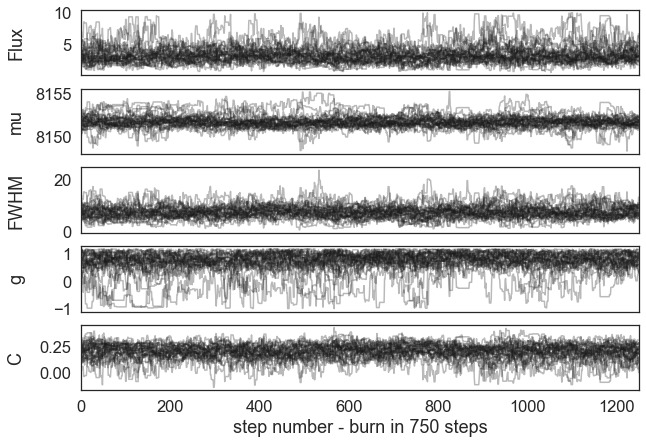

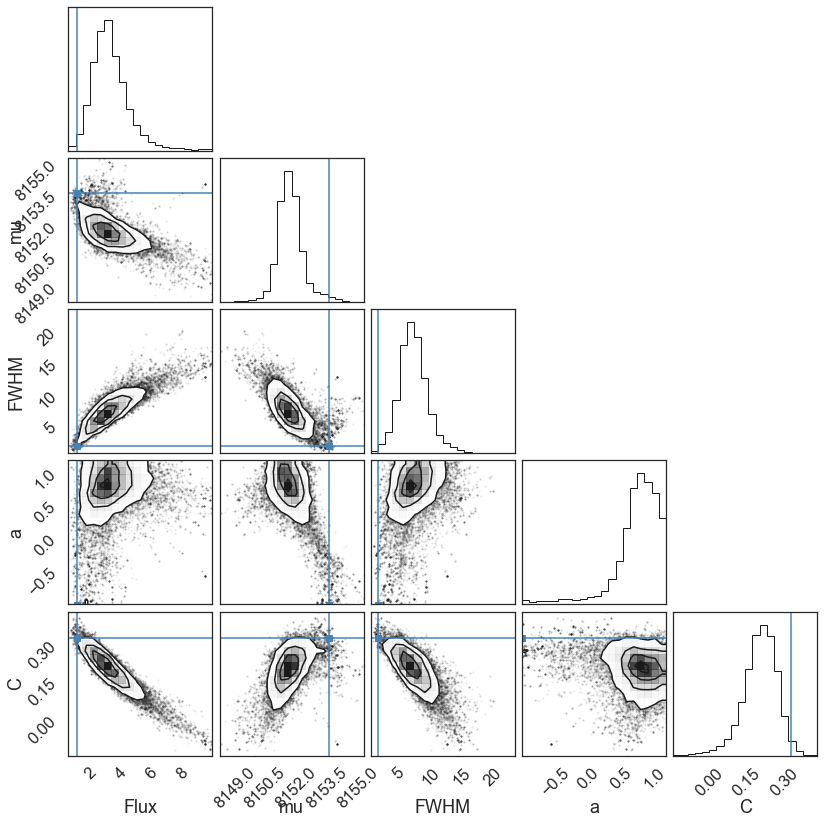

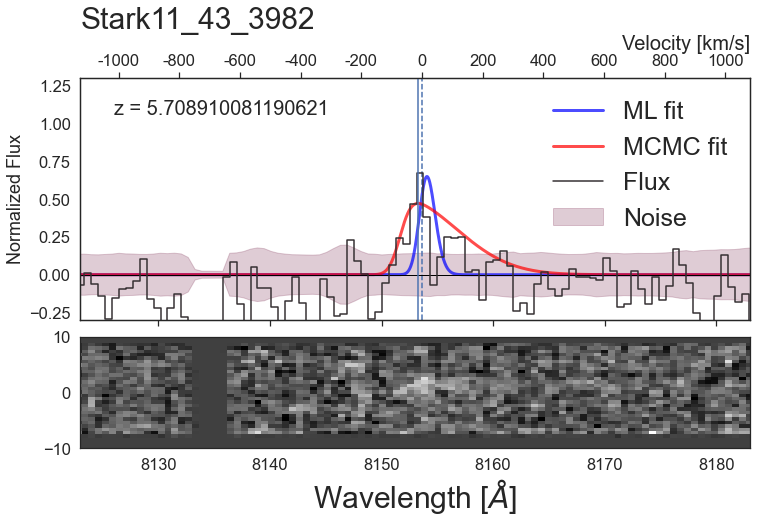

  2%|▏         | 38/2000 [00:00<00:05, 377.91it/s]

4.118888527288963e-18
z5_GND_44499
Exception {'ID': 'z5_GND_44499', 'LW': 8115, 'RW': 8130, 'CW': 8120, 'Skip': True}
z5_GND_7766
Exception {'ID': 'z5_GND_7766', 'LW': 8005, 'RW': 8020, 'CW': 8010, 'Skip': None}
6.107053478861275


100%|██████████| 2000/2000 [00:04<00:00, 468.42it/s]


(37500, 5)
6.0417481890194 8009.643618425534 9.462372096673278
area = 1.8859367073771972e-16
WAVE PEAK:  8011.737593143719


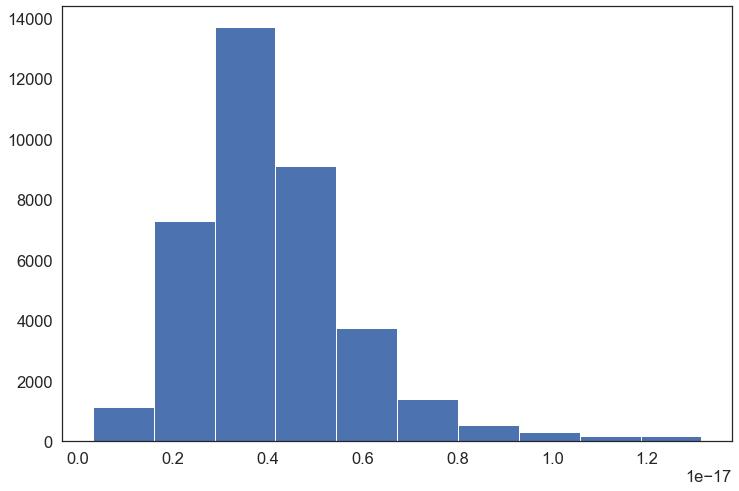

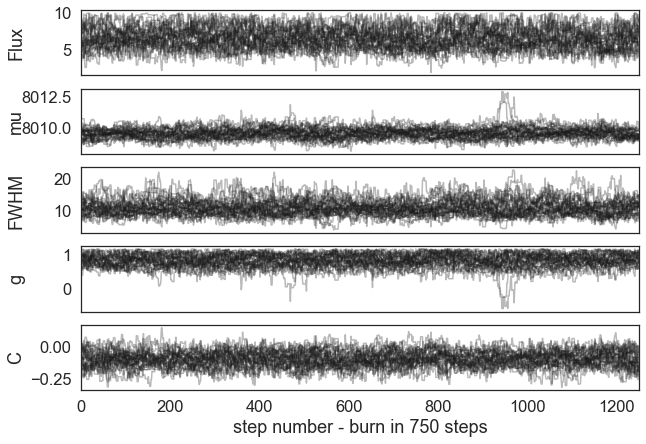

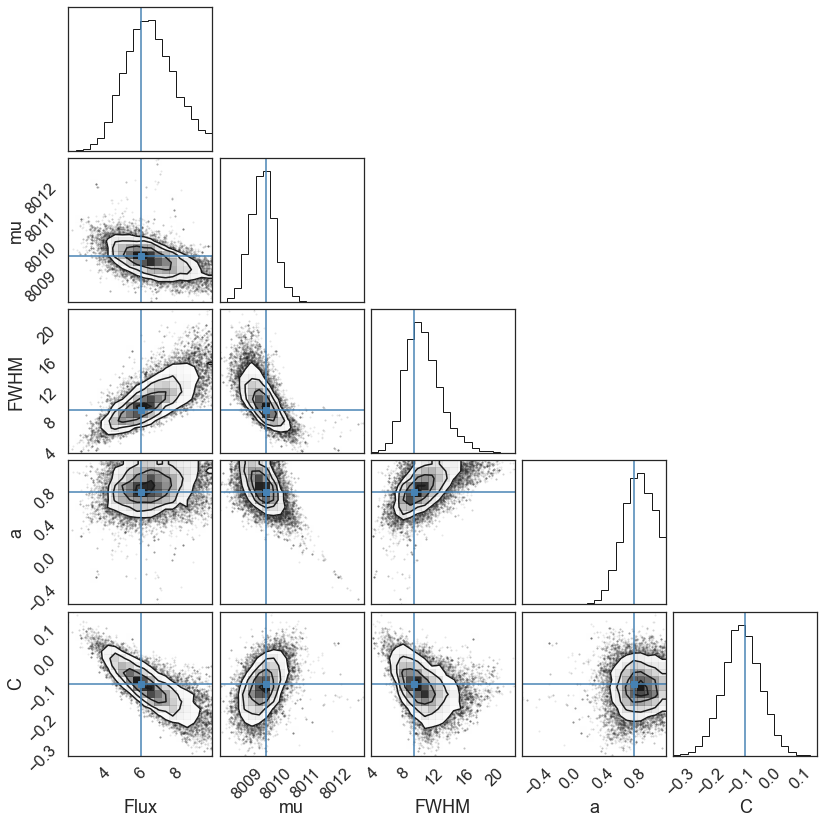

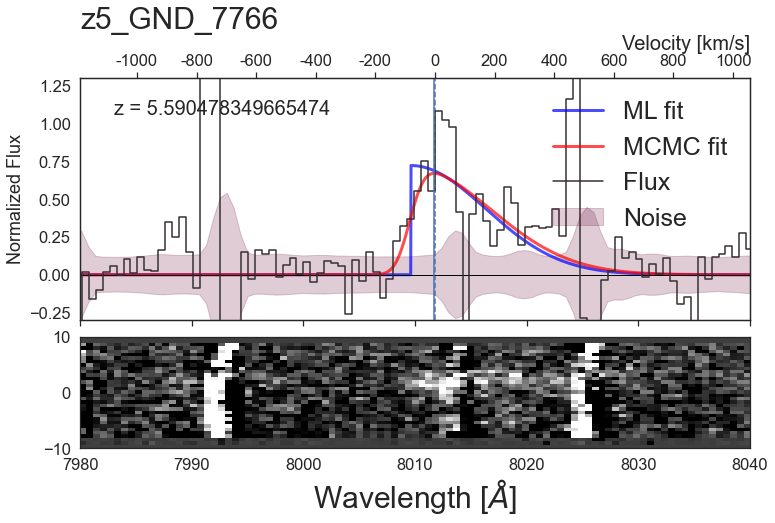

  3%|▎         | 51/2000 [00:00<00:03, 508.42it/s]

9.727965295706542e-18
z7_GND_8358
Exception {'ID': 'z7_GND_8358', 'LW': 9480, 'RW': 9516, 'CW': 9496, 'Skip': None}
0.1


100%|██████████| 2000/2000 [00:04<00:00, 461.78it/s]


(37500, 5)
3.77919906177289 9505.440679708563 7.509377749973589
area = 1.864642951745403e-16
WAVE PEAK:  9501.726590400267


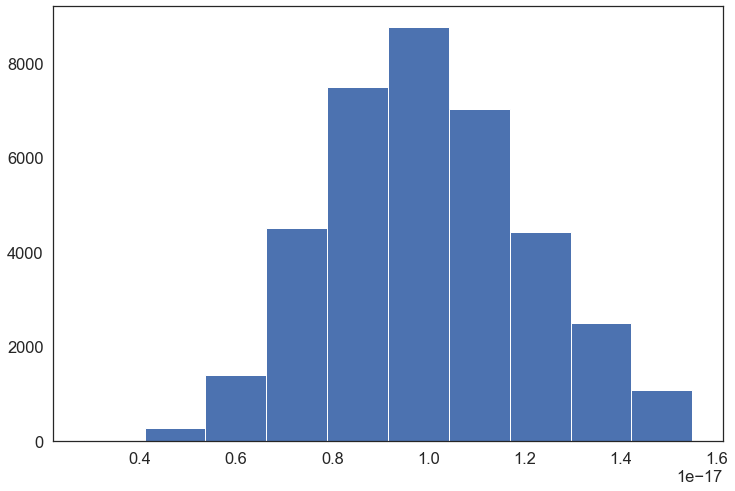

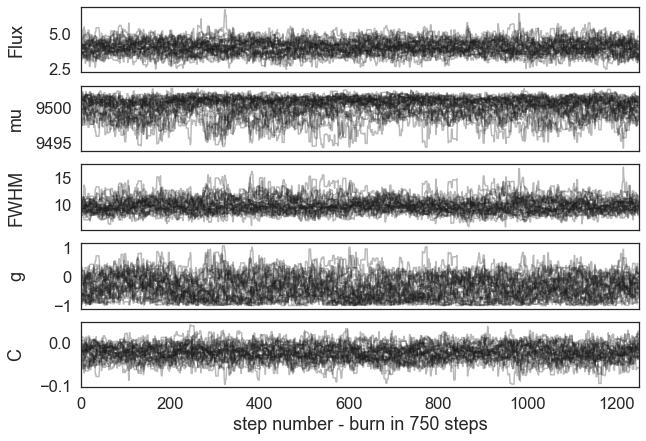

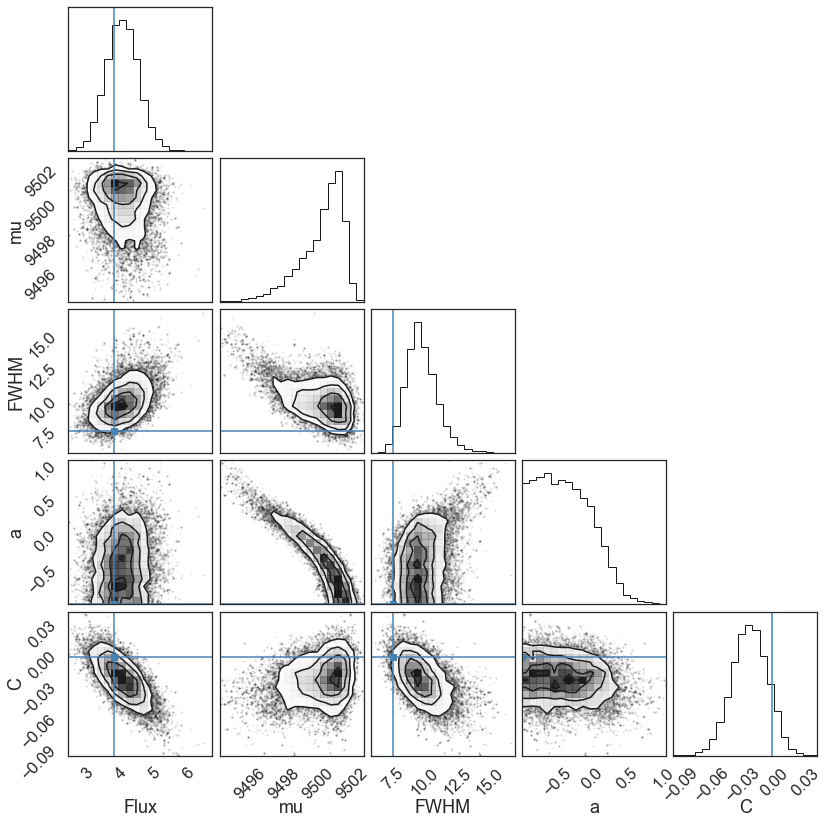

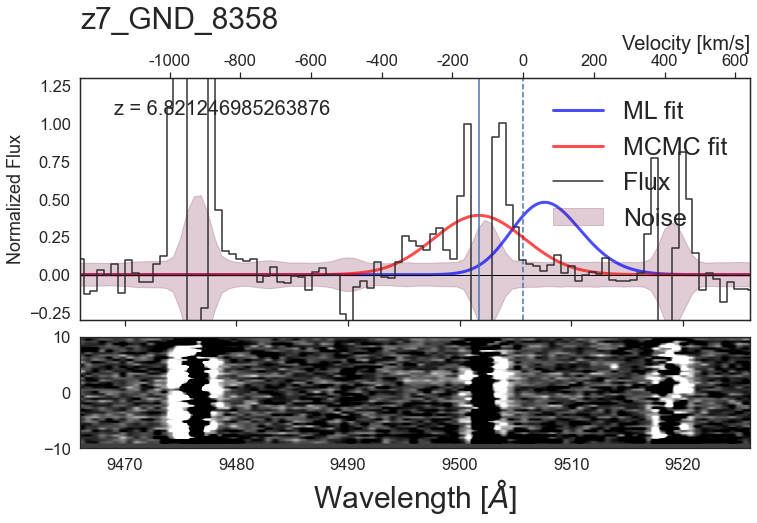

  3%|▎         | 62/2000 [00:00<00:03, 616.22it/s]

9.570264336441799e-18
z6_GND_42333
Exception {'ID': 'z6_GND_42333', 'LW': 9350, 'RW': 9375, 'CW': 9360, 'Skip': True}
z6_GND_7095
Exception {'ID': 'z6_GND_7095', 'LW': 9195, 'RW': 9210, 'CW': 9205, 'Skip': True}
z6_GND_41463
Exception {'ID': 'z6_GND_41463', 'LW': 0, 'RW': 0, 'CW': 0, 'Skip': True}
z7_GND_5323
Exception {'ID': 'z7_GND_5323', 'LW': 0, 'RW': 0, 'CW': 0, 'Skip': True}
Jung18_z6_GND_5752
No exception
15


  6%|▌         | 124/2000 [00:00<00:05, 332.70it/s]Traceback (most recent call last):
  File "/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-8-298fc9e3f63d>", line 53, in log_probability
    lp = log_prior(theta,meanL,meanG)
  File "<ipython-input-8-298fc9e3f63d>", line 28, in log_prior
    flux, mu,FWHM,g,C = theta
KeyboardInterrupt
  7%|▋         | 144/2000 [00:00<00:05, 362.48it/s]

emcee: Exception while calling your likelihood function:
  params: [6.01037960e+00 9.21994551e+03 6.74499397e+00 1.06765312e+00
 2.54226432e-02]
  args: (array([9202.18001878, 9202.80001879, 9203.42001879, 9204.0400188 ,
       9204.6600188 , 9205.28001881, 9205.90001881, 9206.52001882,
       9207.14001882, 9207.76001883, 9208.38001883, 9209.00001884,
       9209.62001884, 9210.24001884, 9210.86001885, 9211.48001885,
       9212.10001886, 9212.72001886, 9213.34001887, 9213.96001887,
       9214.58001888, 9215.20001888, 9215.82001889, 9216.44001889,
       9217.0600189 , 9217.6800189 , 9218.30001891, 9218.92001891,
       9219.54001892, 9220.16001892, 9220.78001893, 9221.40001893,
       9222.02001894, 9222.64001894, 9223.26001894, 9223.88001895,
       9224.50001895, 9225.12001896, 9225.74001896, 9226.36001897,
       9226.98001897, 9227.60001898, 9228.22001898, 9228.84001899,
       9229.46001899, 9230.080019  , 9230.700019  , 9231.32001901,
       9231.94001901, 9232.56001902, 9233.

KeyboardInterrupt: 

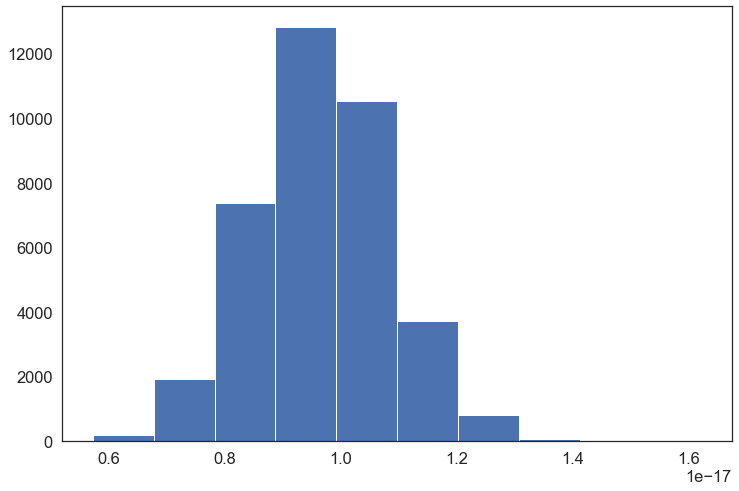

In [12]:
DO_FITTING=True


from scipy.integrate import simps
from scipy import stats
from numpy import trapz
from exception import *
sns.set_theme(style="white",font_scale = 1.5)
plt.rcParams["figure.figsize"] = (12,8)

def getValues(wave,f,ferr,mx=None):
    x=wave
    if mx==None:
        mx=max(f)
    y=f/mx
    yerr=ferr/mx
    original_yerr=ferr/mx
    x0 = np.linspace(min(x), max(x), 5000)
    return x,mx,y,yerr,original_yerr,x0

wave2D=np.arange(6760.0,6760.0+5631*0.620000004768,0.620000004768)

if DO_FITTING==True:
    All_Dist=[]
    Coords=[]
    for A in ALL[:]:
        print(A[4])
        clambda=A[3]
        ID=A[4]


        Ra=A[6]
        Dec=A[7]


        exc = [e  for e in giveExceptions() if e['ID']==A[4]] #Match ID to exception ID
        if exc==[]:
            print("No exception")
            excStatus=False
            eks=20
            mask=(A[0]>clambda-eks) & (A[0]<clambda+eks)


        elif len(exc)!=0:
            exc=exc[0]
            print("Exception",exc)
            excStatus=True
            
            if exc['Skip']==True:
                continue

            elif exc['CW']!=None:
                clambda=exc["CW"]
            mask = (A[0] >= exc['LW']) & (A[0] <= exc['RW'])  #mask with exception


        ORIGINAL_wavelength=A[0]
        ORIGINAL_flux=A[1]
        ORIGINAL_ferr=A[2]

        wave=A[0][mask]
        f=A[1][mask]
        ferr=A[2][mask]
        x,mx,y,yerr,original_yerr,x0 = getValues(wave,f,ferr)
        ORIGINAL_x,ORIGINAL_mx,ORIGINAL_y,ORIGINAL_yerr,ORIGINAL_original_yerr,ORIGINAL_x0 = getValues(ORIGINAL_wavelength,ORIGINAL_flux,ORIGINAL_ferr,mx)


        doubles=Double_peaked()
        if str(A[4]) not in doubles:
            nll = lambda *args: -log_likelihood_ML(*args)   #ML fit
            initial = np.array([0, clambda, 10 , 0 , 0])
            soln = minimize(nll, initial, args=(x, y, yerr))
            flux_ml, mu_ml,FWHM_ml,g_ml,C_ml = soln.x
            if g_ml>15:
                g_ml=15
            if g_ml<0.1:
                g_ml=0.1
            ml_params=np.array([flux_ml,mu_ml,FWHM_ml,np.log10(g_ml),C_ml])
            

            print(g_ml)



            pos = ml_params + W
            nwalkers, ndim = pos.shape
            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(x, y, yerr,clambda,g_ml)
            )
            sampler.run_mcmc(pos, 2000, progress=True)  #steps
            
            
            fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
            samples = sampler.get_chain(discard=750)
            labels = ["Flux", "mu", "FWHM","g","C"]
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number - burn in 750 steps")
            #plt.clf()
            #plt.show()


        #Burn in discards 750

            labels = ["Flux", "mu","FWHM","a","C"]
            samples = sampler.get_chain(discard=750,flat=True)
            print(np.shape(samples))
            fig = corner.corner(samples, labels=labels, truths=[flux_ml,mu_ml,FWHM_ml,np.log10(g_ml),C_ml]) #show quartiles?
            print(flux_ml,mu_ml,FWHM_ml)
            #plt.savefig('plots/profiles/Transparent/mcmc_'+str(A[4])+".png",dpi=200,transparent=True, bbox_inches = "tight")
            #plt.clf()
            #plt.show()
            samples=np.transpose(samples)





            yfunc=skewed_gaussian(ORIGINAL_x0,flux_ml,mu_ml,FWHM_ml,g_ml,C_ml)-C_ml            
            area = trapz(yfunc, dx=0.62)
            print("area =", area*max(f))

            # Compute the area using the composite Simpson's rule.
            #area = simps(yfunc, dx=0.62)
            #print("area =", area*mx)


            id_peak=np.where(skewed_gaussian(x,*ml_params) == max(skewed_gaussian(x,*ml_params)))
            id_peak0=np.where(skewed_gaussian(x0,*ml_params) == max(skewed_gaussian(x0,*ml_params)))
            
            #vel=angstromTokms(x[id_peak],x)
            #vel0=angstromTokms(x0[id_peak],x0)


            fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True)
            ax2 = ax1.twiny()
            #ax1.plot(ORIGINAL_x0,skewed_gaussian(ORIGINAL_x0,*ml_params)-C_ml,'purple',lw=3,alpha=0.7)
            ax1.plot(ORIGINAL_x0,yfunc,'blue',lw=3,alpha=0.7,label="ML fit")

            ax1.axvline(x=np.round(x0[id_peak0],3),ls="--")
            ax3.imshow(A[5],extent=[min(wave2D),max(wave2D),-10,10],aspect=0.5,cmap='gray',vmin=-0.5*np.std(A[5]),vmax=1.5*np.std(A[5]))



            #ax1.plot(x,original_yerr,color='cyan',ls='--',lw=1,alpha=0.5,label='Background')
            #ax1.plot(x,yerr,color='green',ls='--',lw=2,alpha=0.5,label='Background')
            ax1.plot(ORIGINAL_x0,skewed_gaussian(ORIGINAL_x0,*np.median(samples,axis=1))-np.median(samples[4]),'red',lw=3,alpha=0.7,label="MCMC fit")

            gausiana=skewed_gaussian(ORIGINAL_x0,*np.median(samples,axis=1))-np.median(samples[4])
            id_peak=np.where(gausiana == max(gausiana))
            print("WAVE PEAK: ",ORIGINAL_x0[id_peak][0])
            plt.axvline(x=ORIGINAL_x0[id_peak][0])
            ax1.axhline(y=0,color='black',lw=1)
            #ax1.errorbar(x,y,yerr=yerr,marker=".",color='blue',ls="")


            ax1.step(ORIGINAL_x,ORIGINAL_y-C_ml,color='#342E31',label='Flux')
            ax1.fill_between(ORIGINAL_x,-ORIGINAL_yerr,ORIGINAL_yerr,color='#630330',alpha=0.2,zorder=-10,label='Noise')





            #ax1.set_xticks(np.append(ax1.get_xticks(), np.round(x0[id_peak0],3)))
            ax2.set_xticks(ax1.get_xticks())
            ax2.set_xbound(ax1.get_xbound())
            ax2.set_xticklabels([ np.round(angstromTokms(x0[id_peak0],w)[0],2) for w in ax1.get_xticks()])

            #ax1.set_xticks(fix_XTicks(ax1.get_xticks(),'wave'))
            #ax1.set_xticklabels(fix_XTicks(ax1.get_xticks(),'wave'))
            ax2.set_xticks(fix_XticksVelocities(x0[id_peak0][0],'kms')[0])
            ax2.set_xticklabels(fix_XticksVelocities(x0[id_peak0][0],'kms')[1])

            ax1.text(  # position text relative to Axes
                            0.05, 0.85, 'z = '+str(redshift(mu_ml)),
                            transform=ax1.transAxes, size=20
            )


            ax3.set_xlabel(r"Wavelength [$\AA$]",fontsize=30)
            ax1.set_ylabel("Normalized Flux")
            ax2.set_xlabel("Velocity [km/s]",loc='right',fontsize=20)
            ax1.set_title(str(A[4]),fontsize=30,loc='left')
            ax1.set_ylim(-0.3,1.3)
            ax2.set_ylim(-0.3,1.3)
            ax1.set_xlim(clambda-30,clambda+30)
            ax2.set_xlim(clambda-30,clambda+30)
            ax1.legend(loc=1,fontsize=25)
            plt.subplots_adjust(wspace=-0.2, hspace=-0.2)
            #plt.savefig('../figues/profiles/'+str(A[4])+".png",dpi=200, bbox_inches = "tight")
            #plt.clf()
            plt.show()

            #save values

            samples[0]=samples[0]*max(f)
            samples[4]=samples[4]*max(f)

            plt.hist(samples[0]-samples[4])
            print(np.median(samples[0]))
            #plt.show()


            dist_data={}
            dist_data["amp"]=samples[0]
            dist_data["loc"]=samples[1]
            dist_data["fwhm"]=samples[2]#/(2*np.sqrt(2*np.log(2)))
            dist_data["g"]=samples[3]
            dist_data["C"]=samples[4]
            dist_data["peak"]=ORIGINAL_x0[id_peak][0]


            ML_data={}
            
            ML_data["amp"]=flux_ml
            ML_data["loc"]=mu_ml
            ML_data["fwhm"]=FWHM_ml#/(2*np.sqrt(2*np.log(2)))
            ML_data["g"]=g_ml
            ML_data["C"]=C_ml

            Name={}
            Name["ID"]= str(A[4])

            
            All_Dist.append([dist_data,ML_data,Name])
            Coords.append([ID,Ra,Dec])


    # For Double peaked::


        if str(A[4]) in doubles:
            
            nll = lambda *args: -Double_log_likelihood_ML(*args)   #ML fit

            if '28438' in str(A[4]):
                print("AAAAA")
                initial = np.array([0, clambda, 10 , 0 ,0, clambda-11, 1 , 0 , 0])
            if "Hu10_z7_1" in str(A[4]):
                initial = np.array([0, clambda, 10 , 0 ,0, clambda, 1 , 0 , 0])
            if "z6_GNW_4311" in str(A[4]):
                initial = np.array([0, clambda, 10 , 0 ,0, clambda-5, 1 , 0 , 0])
            if "z6_GNW_9770" in str(A[4]):
                initial = np.array([0, clambda, 10 , 0 ,0, clambda-3, 1 , 0 , 0])
            if "z7_GND_11401" in str(A[4]):
                initial = np.array([0, clambda, 10 , 0 ,0, clambda-3, 1 , 0 , 0])

            soln = minimize(nll, initial, args=(x, y, yerr))
            flux1_ml, mu1_ml,FWHM1_ml,g1_ml,flux2_ml, mu2_ml,FWHM2_ml,g2_ml,C_ml = soln.x
            ml_params=[flux1_ml,mu1_ml,FWHM1_ml,g1_ml,flux2_ml,mu2_ml,FWHM2_ml,g2_ml,C_ml]
                
            
            """
            pos = soln.x + W2
            nwalkers, ndim = pos.shape
            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(x, y, yerr,clambda,g1_ml)
            )
            sampler.run_mcmc(pos, 2000, progress=True)  #steps
            
            
            fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
            samples = sampler.get_chain(discard=750)
            labels = ["Flux1", "mu1", "FWHM1","g1","Flux2", "mu2", "FWHM2","g2","C"]
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number - burn in 750 steps")
            plt.show()

            
        #Burn in discards 750

            labels = ["Flux", "mu","FWHM","g","Flux2", "mu2","FWHM2","g2","C"]
            samples = sampler.get_chain(discard=750,flat=True)
            print(np.shape(samples))
            fig = corner.corner(samples, labels=labels, truths=ml_params) #show quartiles?
            plt.show()
            samples=np.transpose(samples)

            """ 

            yfunc=Double_skewed_gaussian_ML(x0,*ml_params)-C_ml
            area = trapz(yfunc, dx=0.62)
            print("area =", area*mx)

            # Compute the area using the composite Simpson's rule.
            area = simps(yfunc, dx=0.62)
            print("area =", area*mx)
            

            id_peak=np.where(Double_skewed_gaussian_ML(x,*ml_params) == max(Double_skewed_gaussian_ML(x,*ml_params)))
            id_peak0=np.where(Double_skewed_gaussian_ML(x0,*ml_params) == max(Double_skewed_gaussian_ML(x0,*ml_params)))
            
            #vel=angstromTokms(x[id_peak],x)
            #vel0=angstromTokms(x0[id_peak],x0)


            fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True)
            ax2 = ax1.twiny()
            ax1.plot(ORIGINAL_x0,skewed_gaussian_ML(ORIGINAL_x0,ml_params[0],ml_params[1],ml_params[2],ml_params[3],ml_params[8])-C_ml,'black','--',lw=1,alpha=0.5)
            ax1.plot(ORIGINAL_x0,skewed_gaussian_ML(ORIGINAL_x0,ml_params[4],ml_params[5],ml_params[6],ml_params[7],ml_params[8])-C_ml,'black','--',lw=1,alpha=0.5)
            ax1.plot(ORIGINAL_x0,Double_skewed_gaussian_ML(ORIGINAL_x0,*ml_params)-C_ml,'purple',lw=3,alpha=0.7,label="ML fit")
            gausiana=Double_skewed_gaussian_ML(ORIGINAL_x0,*ml_params)-C_ml
            id_peak=np.where(gausiana == max(gausiana))
            print("WAVE PEAK: ",ORIGINAL_x0[id_peak][0])


            ax1.axvline(x=np.round(x0[id_peak0],3),ls="--")
            ax3.imshow(A[5],extent=[min(wave2D),max(wave2D),-10,10],aspect=0.5,cmap='gray',vmin=-5*np.std(A[5]),vmax=2*np.std(A[5]))
            
            #ax1.plot(x,original_yerr,color='cyan',ls='--',lw=1,alpha=0.5,label='Background')
            #ax1.plot(x,yerr,color='green',ls='--',lw=2,alpha=0.5,label='Background')
            #ax1.plot(x0,Double_skewed_gaussian(x0,*stats.mode(samples,axis=1)[0]),'red',lw=3,alpha=0.7,label="MCMC fit")
            ax1.axhline(y=0,color='black',lw=1)
            #ax1.errorbar(x,y,yerr=yerr,marker=".",color='blue',ls="")
            ax1.step(ORIGINAL_x,ORIGINAL_y-C_ml,color='#342E31')
            ax1.fill_between(ORIGINAL_x,ORIGINAL_yerr,-ORIGINAL_yerr,color='#630330',alpha=0.2,zorder=-10)
            ax1.text(  # position text relative to Axes
                            0.05, 0.85, 'z = '+str(redshift(mu1_ml)),
                            transform=ax1.transAxes, size=20
            )


            ax1.set_xticks(np.append(ax1.get_xticks(), np.round(x0[id_peak0],3)))
            ax2.set_xticks(ax1.get_xticks())
            ax2.set_xbound(ax1.get_xbound())
            ax2.set_xticklabels([ np.round(angstromTokms(x0[id_peak0],w)[0],2) for w in ax1.get_xticks()])


            ax1.set_xticks(fix_XTicks(ax1.get_xticks(),'wave'))
            ax1.set_xticklabels(fix_XTicks(ax1.get_xticks(),'wave'))
            ax2.set_xticks(fix_XticksVelocities(x0[id_peak0][0],'kms')[0])
            ax2.set_xticklabels(fix_XticksVelocities(x0[id_peak0][0],'kms')[1])
            

            ax1.set_xlabel("Wavelength")
            ax1.set_ylabel("Normalized Flux")
            ax2.set_xlabel("Velocity [km/s]",loc='right')
            ax1.set_title(str(A[4]),fontsize=25,loc='left')
            ax1.set_ylim(-0.3,1.)
            ax2.set_ylim(-0.3,1.)
            ax1.set_xlim(clambda-30,clambda+30)
            ax2.set_xlim(clambda-30,clambda+30)
            ax1.legend(loc=1)
            plt.subplots_adjust(wspace=-0.4, hspace=-0.4)
            #plt.savefig('../figues/profiles/'+str(A[4])+".png",dpi=200, bbox_inches = "tight")
            #plt.clf()
            plt.show()



            """    
            
            dist_data={}
            dist_data["amp"]=samples[0]*max(A[1])
            dist_data["mu"]=samples[1]
            dist_data["fwhm"]=samples[2]
            dist_data["g"]=samples[3]
            dist_data["amp2"]=samples[4]*max(A[1])
            dist_data["mu2"]=samples[5]
            dist_data["fwhm2"]=samples[6]
            dist_data["g2"]=samples[7]
            dist_data["C"]=samples[8]
            """

            ML_data={}
            
            ML_data["amp"]=flux1_ml*max(f)
            ML_data["loc"]=mu1_ml
            ML_data["fwhm"]=FWHM1_ml
            ML_data["g"]=g1_ml
            ML_data["amp2"]=flux2_ml*max(f)
            ML_data["loc2"]=mu2_ml
            ML_data["fwhm2"]=FWHM2_ml
            ML_data["g2"]=g2_ml
            ML_data["C"]=C_ml*max(f)
            ML_data["peak"]=ORIGINAL_x0[id_peak][0]

            Name={}
            Name["ID"]= str(A[4])


            All_Dist.append([np.nan,ML_data,Name])
            Coords.append([ID,Ra,Dec])

    #np.save("Prob_Dist22March24.npy",All_Dist)

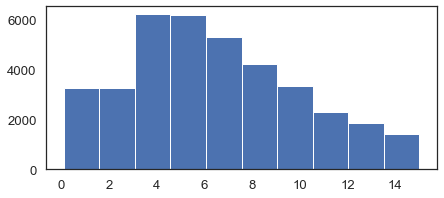

(69, 3)
G : 
[ 5.52128059  6.65160978  0.12207091 14.65284874  7.07329289  6.39960212
 14.76109237 13.66400363  0.11053683  0.11057326  6.09658923  8.18192749
  0.10001183  7.51570213  3.87955321  3.92622375 14.56937843  9.09022252
 14.26643103  6.14646369 10.05178301  6.03770188  5.74563554         nan
  0.24628843  2.20449412 14.26595341  0.10297482  5.78850778 14.76518762
  3.97251168 11.14223372 12.78664354 11.6790073   0.11618898 14.26598915
  8.00565762         nan 14.24402356  4.9415527   1.05359927  9.55949048
  6.11971348 14.4177024   1.91782413  5.47203906 13.59535909  8.56071446
 14.4177024   1.18968742  0.15705596  6.08890919  0.31661513         nan
  0.10001188 14.27036436  8.3323447   0.11152238 10.82525304  3.69335502
         nan 13.8697461  13.1756956   0.11040932  4.98236873 14.74337718
  8.93634466  1.7417812   1.89466676]
69
69
Stark11_43_3982 5.5212805857705884
z5_GND_7766 6.65160977918136
z7_GND_8358 0.12207091486386507
Jung18_z6_GND_5752 14.652848739717783
Stark1

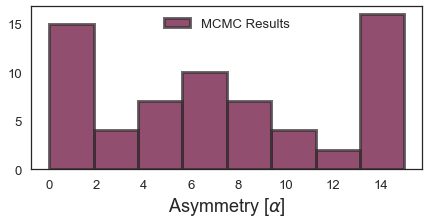

SKEWNESS
[0.90293471 0.92969248 0.02679179 0.98098664 0.93681803 0.92481149
 0.98119233 0.97888059 0.02423142 0.0242395  0.91820836 0.95090557
 0.02190251 0.9431357  0.8250658  0.8283861  0.98082494 0.95901201
 0.98021454 0.91935562 0.96541301 0.916821   0.90937315        nan
 0.05511882 0.61222026 0.98021354 0.02255746 0.9105291  0.98120003
 0.83159079 0.97083059 0.97659904 0.97297492 0.02548498 0.98021362
 0.94902511        nan 0.98016787 0.88268756 0.29153737 0.96236609
 0.9187434  0.98052404 0.54764615 0.90142843 0.9787175  0.95458283
 0.98052404 0.33618198 0.03461844 0.91802946 0.07197747        nan
 0.02190252 0.98022271 0.95242237 0.02444985 0.96941719 0.81086687
        nan 0.97935532 0.97766569 0.02420317 0.8843122  0.98115897
 0.95780145 0.5024715  0.5419461 ]


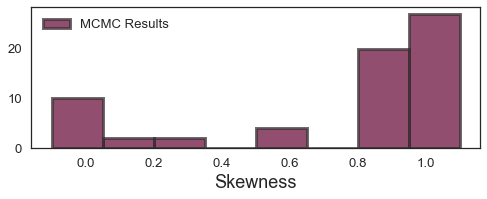

[0.90293471 0.92969248 0.02679179 0.98098664 0.93681803 0.92481149
 0.98119233 0.97888059 0.02423142 0.0242395  0.91820836 0.95090557
 0.02190251 0.9431357  0.8250658  0.8283861  0.98082494 0.95901201
 0.98021454 0.91935562 0.96541301 0.916821   0.90937315        nan
 0.05511882 0.61222026 0.98021354 0.02255746 0.9105291  0.98120003
 0.83159079 0.97083059 0.97659904 0.97297492 0.02548498 0.98021362
 0.94902511        nan 0.98016787 0.88268756 0.29153737 0.96236609
 0.9187434  0.98052404 0.54764615 0.90142843 0.9787175  0.95458283
 0.98052404 0.33618198 0.03461844 0.91802946 0.07197747        nan
 0.02190252 0.98022271 0.95242237 0.02444985 0.96941719 0.81086687
        nan 0.97935532 0.97766569 0.02420317 0.8843122  0.98115897
 0.95780145 0.5024715  0.5419461 ]


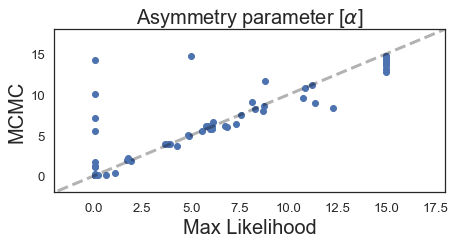

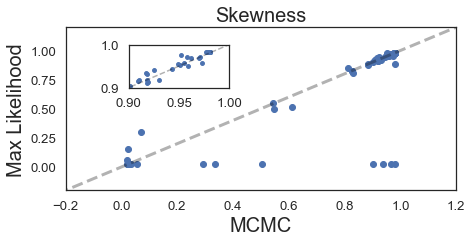

In [25]:
plt.rcParams["figure.figsize"] = (7,3)

All_Dist=np.load("Prob_Dist22March24.npy",allow_pickle=True)
plt.hist(10**All_Dist[0][0]["g"])
plt.show()
def MedianHist(vals,bins):
    bin_centers=[(bins[i]+bins[i+1])/2 for i in range(0,len(bins[:-1]))]
    allVals=[]
    counter=0
    for val in vals:
        for i in range(0,val):
            allVals.append(bin_centers[counter])
        counter+=1

    return np.array([np.percentile(allVals,50),np.mean([np.percentile(allVals,50)-np.percentile(allVals,16),np.percentile(allVals,84)-np.percentile(allVals,50)])])
    
def recover_param(data,key):
    ml=[]
    mcmc=[]
    for d in data:
        ml.append(d[1][key])
        try:
            val,bin = np.histogram(d[0][key],bins=100)

            index = np.where(val == max(val)) #Put median
            mcmc.append(bin[index[0][0]])
        except:
            mcmc.append(np.nan)
        '''
        Make something for gaussian PDFs, and non gaussian PDfs
        fit a gaussian to see if it is gaussian or it isnt
        '''
        
    return np.array(ml),10**np.array(mcmc)

def skewness_func(g):
    delta=g/(np.sqrt(1+g**2))
    skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
    return skewness


print(np.shape(All_Dist))

gs_ml,gs_mcmc=recover_param(All_Dist,"g")
print("G : ")
print(gs_mcmc)
print(len(gs_mcmc))
print(len(All_Dist))
skew_res={"ID":[],"g":[]}
for i in range(0,len(gs_mcmc)):
    print(All_Dist[i][2]["ID"],gs_mcmc[i])
    skew_res["ID"].append(All_Dist[i][2]["ID"])
    skew_res["g"].append(gs_mcmc[i])

np.save("skewness.npy",skew_res)


#mask=(gs_ml<20) & (gs_ml>-20)

sns.set_theme(style="white",font_scale = 1.2)

binaje=8
kws = dict( linewidth = 3,edgecolor="#342E31",color='#630330',alpha=0.7)
#plt.hist(gs_ml,range=[0,15],bins=binaje,label='ML Results',alpha=0.4,color="#342E31")
plt.hist(gs_mcmc,range=[0,15],bins=binaje,label='MCMC Results',**kws)
print(np.sort(gs_mcmc))
plt.xlabel(r"Asymmetry [$\alpha$]",size=18)
plt.legend()
plt.show()

binaje=8
print("SKEWNESS")
print(skewness_func(gs_mcmc))
plt.hist(skewness_func(gs_mcmc),range=[-0.1,1.1],bins=binaje,label='MCMC Results',**kws)
plt.xlabel("Skewness",size=18)
plt.legend()
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/skewness.png',dpi=200,transparent=True)
            
plt.show()
print(skewness_func(gs_mcmc))



plt.plot([-1000,1000],[-1000,1000],'--',lw=3,color="black",alpha=0.3)
plt.scatter(gs_ml,gs_mcmc)
plt.xlim(-2,18)
plt.ylim(-2,18)
plt.xlabel("Max Likelihood",size=20)
plt.ylabel("MCMC",size=20)
plt.title(r"Asymmetry parameter [$\alpha$]",size=20)
#plt.savefig('plots/profiles/Transparent/skewness.png',dpi=200,transparent=True)
            
plt.show()





fig, ax1 = plt.subplots()
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])



ax1.plot([-1000,1000],[-1000,1000],'--',lw=3,color="black",alpha=0.3)
ax1.scatter(skewness_func(gs_mcmc),skewness_func(gs_ml))
ax1.set_xlim(-0.2,1.2)
ax1.set_ylim(-0.2,1.2)
ax1.set_ylabel("Max Likelihood",size=20)
ax1.set_xlabel("MCMC",size=20)
ax1.set_title("Skewness",size=20)

ax2.plot([-1000,1000],[-1000,1000],'--',lw=1.5,color="black",alpha=0.3)
ax2.scatter(skewness_func(gs_mcmc),skewness_func(gs_ml),s=15)
ax2.set_xlim(0.9,1)
ax2.set_ylim(0.9,1)


plt.show()

In [21]:
All_Dist[0][2]

{'ID': 'Stark11_43_3982'}

0.7252870829054425
8153.637929771776
6.518509492897392
8011.793618436495
3.1990370832607784
9505.690679719482


NameError: name 'kws' is not defined

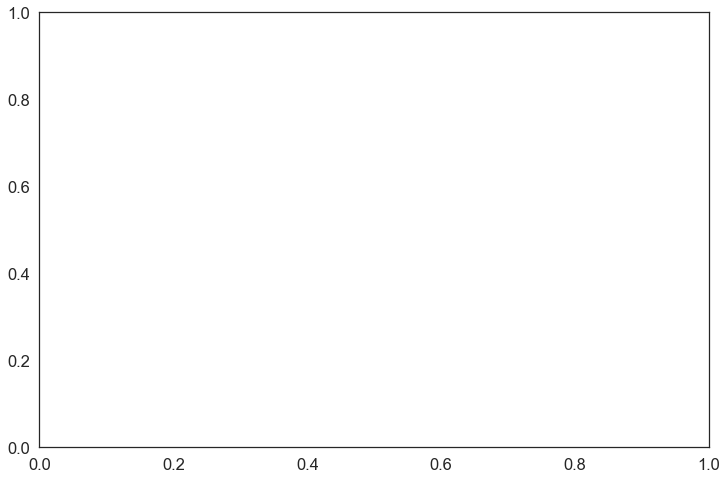

In [13]:
def recover_param(data,key):
    ml=[]
    mcmc=[]
    for d in data:
        ml.append([d[1][key],np.nan])
        try:
            val,bin = np.histogram(d[0][key],bins=100,range=[d[1][key]-10,d[1][key]+10])

            #plt.plot(bin[:-1],val)
            #plt.axvline(x=MedianHist(val,bin),color="gray",label="median")
            index = np.where(val == max(val)) #Put median
            #plt.axvline(x=bin[index[0][0]],color="red",label="max")
            #plt.legend()
            #plt.title(str(key))
            #plt.clf()
            #plt.show()
            mcmc.append(MedianHist(val,bin))
        except:
            mcmc.append([np.nan,np.nan])
        '''
        Make something for gaussian PDFs, and non gaussian PDfs
        fit a gaussian to see if it is gaussian or it isnt
        '''
        
    return np.array(ml),np.array(mcmc)

def onlyCentralValue(data):
    return np.array([i[0] for i in data])

def only1sigma(data):
    return np.array([i[1] for i in data])

ml_loc,mcmc_loc=recover_param(All_Dist,"loc")
ml_fwhm,mcmc_fwhm=recover_param(All_Dist,"fwhm")
gs_ml,gs_mcmc=recover_param(All_Dist,"g")




#gs_ml,gs_mcmc

#ml_mu=SkewedMean(ml_loc,ml_scale,gs_ml)

mcmc_loc=onlyCentralValue(mcmc_loc)
mcmc_fwhm=onlyCentralValue(mcmc_fwhm)
gs_mcmc=onlyCentralValue(gs_mcmc)
ml_loc=onlyCentralValue(ml_loc)
ml_fwhm=onlyCentralValue(ml_fwhm)
gs_ml=onlyCentralValue(gs_ml)

mcmc_mu=SkewedMean(mcmc_loc,mcmc_fwhm,gs_mcmc)
mcmc_peak=SkewedPeak(mcmc_loc,mcmc_fwhm,gs_mcmc) # This for redshifts
ml_peak=SkewedPeak(ml_loc,ml_fwhm,gs_ml)
#ml_fwhm=SkewedSTD(ml_scale,gs_ml)
#mcmc_fwhm=SkewedSTD(mcmc_scale,gs_mcmc)



fig, ax1 = plt.subplots()
left, bottom, width, height = [0.65, 0.4, 0.2, 0.2]
#ax2 = fig.add_axes([left, bottom, width, height])


#ax2.plot([-1000,1000],[-1000,1000],'--',lw=1.5,color="black",alpha=0.3)
#ax2.scatter(skewness_func(gs_ml),skewness_func(gs_mcmc),s=15)
#ax2.set_xlim(0.9,1)
#ax2.set_ylim(0.9,1)
#plt.show()

plt.hist(redshift(mcmc_peak),range=[4.9,7.1],bins=15,**kws)
plt.xlabel(r"Redshift$_{Lya}$")
plt.show()


FWHM_kms=angstromTokms(mcmc_peak,mcmc_fwhm)
#np.save("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/files/FWHM.npy",FWHM_kms)


plt.hist(mcmc_fwhm,bins=13,range=[0,26],**kws)
plt.xlabel(r"FWHM$_{Lya}$ [$\AA$]")
plt.show()


plt.rcParams["figure.figsize"] = (7,5)
sns.set_theme(style="white",font_scale = 1.2)
plt.hist(FWHM_kms,range=[0,800],bins=12,**kws)
plt.xlabel(r"FWHM$_{Lya}$ [km/s]",size=20)
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/fwhm.png',dpi=200,transparent=True)
plt.show()



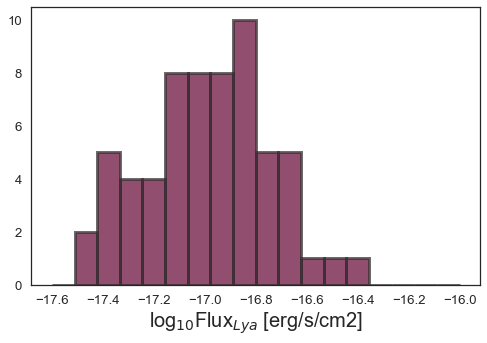

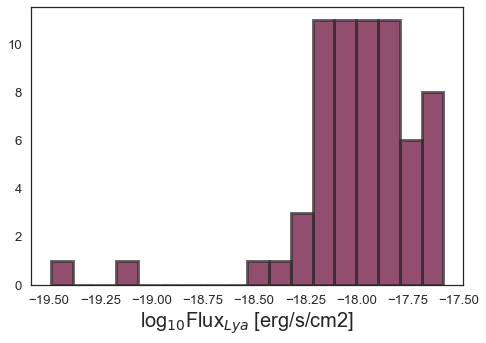

In [ ]:
def recover_param(data,key): #MEDIANS OR MAXs
    ml=[]
    mcmc=[]
    for d in data:
        ml.append([d[1][key],np.nan])
        try:
            val,bin = np.histogram(d[0][key],bins=100)
            #plt.plot(bin[:-1],val)
            #plt.axvline(x=MedianHist(val,bin),color="gray",label="median")
            index = np.where(val == max(val)) #Put median
            #plt.axvline(x=bin[index[0][0]],color="red",label="max")
            #plt.legend()
            #plt.show()
            
            mcmc.append(MedianHist(val,bin))
        except:
            mcmc.append([np.nan,np.nan])
        '''
        Make something for gaussian PDFs, and non gaussian PDfs
        fit a gaussian to see if it is gaussian or it isnt
        '''
        
    return np.array(ml),np.array(mcmc)




ml_flux,mcmc_flux=recover_param(All_Dist,"amp")
ml_flux=onlyCentralValue(ml_flux)
flux_err=only1sigma(mcmc_flux)
mcmc_flux=onlyCentralValue(mcmc_flux)


plt.hist(np.log10(mcmc_flux),bins=18,range=[-17.6,-16],**kws)
plt.xlabel(r"log$_{10}$Flux$_{Lya}$ [erg/s/cm2]",size=20)
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/Fluxes.png',dpi=200,transparent=True)
plt.show()

plt.hist(np.log10(flux_err),bins=18,**kws)
plt.xlabel(r"log$_{10}$Flux$_{Lya}$ [erg/s/cm2]",size=20)
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/Fluxes.png',dpi=200,transparent=True)
plt.show()


In [ ]:
def finderParam(mcmc,ml):
    p=[]
    for i in range(0,len(mcmc)):
        if np.isnan(mcmc[i])==False:
            p.append(mcmc[i])
        elif np.isnan(ml[i])==False:
            p.append(ml[i])
        else:
            p.append(np.nan)
    return np.array(p)

def finderErr(mcmc,flux):
    p=[]
    for i in range(0,len(mcmc)):
        if np.isnan(mcmc[i])==False:
            p.append(mcmc[i])
        else:
            p.append(flux[i]*0.1)
    return np.array(p)


f=finderParam(mcmc_flux,ml_flux)
peaks=finderParam(mcmc_peak,ml_peak)
fwhm=finderParam(mcmc_fwhm,ml_fwhm)
gs=finderParam(gs_mcmc,gs_ml)

fluxErr=finderErr(flux_err,f)

In [ ]:
from astropy.io import ascii
from astropy.table import Table





Id=[i[2]["ID"] for i in All_Dist]

#z=redshift(peaks)
z=[]
for gal in All_Dist:
    try:
        z.append(redshift(gal[0]["peak"]))
    except:
        z.append(redshift(gal[1]["peak"])) 

Lyaflux=np.log10(f)
LyaErr=np.log10(fluxErr)
LyaFWHM=angstromTokms(peaks,fwhm)
Skewness=skewness_func(gs)

print(len(Id))
print(len(z))
print(len(Lyaflux))
print(len(LyaFWHM))
print(len(Skewness))

data = Table()
data['ID'] = Id
data['z'] = z
data["LyaFlux"] =   Lyaflux
data["LyaErr"]  =   LyaErr
data['LyaFWHM'] =   LyaFWHM
data["Skewness"]    =   Skewness
ascii.write(data, '../A-catalogs/BLAS_data22March.cat', overwrite=True) 




69
69
69
69
69


In [ ]:
data

ID,z,LyaFlux,LyaErr,LyaFWHM,Skewness
str19,float64,float64,float64,float64,float64
Stark11_43_3982,5.708932950674238,-17.374197045285047,-17.929845114736338,303.4959548413208,0.20826167073211851
z5_GND_7766,5.591906181481391,-17.1028564388034,-17.719404805889713,445.49494112322935,0.2660183560672995
z7_GND_8358,6.817723679814542,-17.005345945336025,-17.668780268645946,459.42044690447784,0.11767306905184728
Jung18_z6_GND_5752,6.587129426687153,-17.2370774122257,-18.25393745791978,216.07380556504518,0.9775098285114732
Stark11_35_22248,5.6926876376684685,-17.522638910899182,-17.696802285687674,495.2721569018982,0.04437580699518474
Stark11_35_22381,5.6926876376684685,-17.515283068452657,-18.17657311818653,306.3230615517508,0.21585289996093426
Hu10_z6_3,5.633399541760509,-16.757521767709598,-18.118117067538847,355.58207255969427,0.9816309680972053
z5_GNW_2438,5.357951019135256,-17.01529897301636,-17.896959857791536,478.8137051474494,0.9777829102892739
Stark11_42_6706,5.972875762763978,-17.247257030494506,-17.768089988006157,355.3639335152486,-0.044375806995184536


In [ ]:
All_Dist[0][0]["peak"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

g=np.arange(-50,50,1)
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(delta)
print(skewness)
plt.axvline(x=15)
plt.plot(g,skewness)
plt.plot(g,delta)
plt.ylabel("Skewness",size=15)
plt.xlabel(r"g",size=15)
plt.show()
#plt.plot(g,delta)



In [ ]:
print(len(np.arange(6760.0,6760.0+5631*0.620000004768,0.620000004768)))

In [ ]:
mask1=[True,False,False,True]
mask2=[False,True,True,True]

fullmask= [x[0] and x[1] for x in zip(mask1,mask2)]
print(fullmask)

In [ ]:
def skewed_gaussian(x,g) :
    """Gaussian"""
    fw_param=(5/(2*np.sqrt(2*np.log(2))))
    return (1/(fw_param*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x)**2 / fw_param**2)* (1+scispe.erf( g*(x)/(fw_param*np.sqrt(2))))

xx=np.linspace(-15,15,100)
gg=[0,2,5,10,15]
counter=0
print(gg)
for gs in gg:
    plt.plot(xx,skewed_gaussian(xx,gs)/max(skewed_gaussian(xx,gs)),lw=5,alpha=0.4,label=r"$\alpha$="+str(gs))
    counter+=1
plt.xlim(-7,7)
plt.legend()
plt.ylabel("Normalized")
plt.show()


g=np.arange(0,15,0.01)
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(delta)
print(skewness)
#plt.axvline(x=15)
plt.plot(g,skewness,lw=5,alpha=0.4)
#plt.plot(g,delta,lw=5,alpha=0.4)
plt.ylabel("Skewness",size=15)
plt.xlabel(r"$\alpha$",size=15)
plt.show()




plt.rcParams["figure.figsize"] = (3,3)
sns.set_theme(style="white",font_scale = 1.2)
xx=np.linspace(-15,15,1000)
g=np.array([0,1,2,5,15])
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(skewness)
counter=0
print(gg)
for gs in g:
    if counter==0:
        k="Skewness"
    else:
        k=""
    plt.plot(xx,skewed_gaussian(xx,gs)/max(skewed_gaussian(xx,gs)),lw=5,alpha=0.4,label=k+" = "+str(np.round(skewness[counter],1)))
    counter+=1
plt.xlim(-7,7)
plt.legend()
plt.ylabel("Normalized")
plt.xticks(color='w')
plt.tight_layout()
plt.savefig('../data/large_files/plots/profiles/Transparent/fwhm.png',dpi=200,transparent=True)
plt.show()



In [ ]:
a=[1,1,1,1]
b=[]
for i in range(0,11):
    b.append(a)
print(np.shape(b))

In [ ]:
plt.rcParams["figure.figsize"] = (3,3)
sns.set_theme(style="white",font_scale = 1.2)
xx=np.linspace(-15,15,1000)
g=np.array([15])
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(skewness)
counter=0
print(gg)
for gs in g:
    if counter==0:
        k="Skewness"
    else:
        k=""
    plt.plot(xx,skewed_gaussian(xx,gs)/max(skewed_gaussian(xx,gs)),lw=5,alpha=0.4,label=k+" = "+str(np.round(skewness[counter],1)))
    counter+=1
plt.xlim(-7,7)
#plt.legend()
plt.xlabel("Skewness = 1",size=30)
plt.yticks(color='#F2E4EF')
plt.xticks(color='#F2E4EF')
plt.tight_layout()
plt.savefig('../data/large_files/plots/profiles/Transparent/example2.png',dpi=200,transparent=True)
plt.show()

In [ ]:
data_dir = 'data/'
fname_data = np.sort(glob.glob(data_dir+"large_files/Reduced_Data/*/2D/noiseCorrected/*.fits")) #read data
fname_data = [i for i in fname_data if "3DHST" not in i and "f_" not in i] #takes only LAEs
PossibleLines=[]
Specs=[]
for data in fname_data[:]:
    HDU = fits.open(data)
    flux=HDU[0]
    error=HDU[1]
    Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux)  #This is the class that has many functions to manipulate the data


In [ ]:
Ids=[s.Data.header["SLITOBJ"] for s in Specs]
#np.save("Photometry/Catalogs/Bino_IDs.npy",Ids)
